In [10]:
import torch
import os
import numpy as np
from torchdyn.datasets import generate_moons
import matplotlib.pyplot as plt
import math

from tensorclass import TensorMultiModal


class NGaussians:
    def __init__(self, dim=2, vocab_size=8):

        self.dim = dim
        self.num_gaussians = vocab_size


    def __call__(self, num_points, device='cpu') -> TensorMultiModal:

        num_points_per_gaussian = num_points // self.num_gaussians

        angle_step = 2 * np.pi / self.num_gaussians
        positions = []
        labels = []

        for i in range(self.num_gaussians):
            angle = i * angle_step
            center_x = np.cos(angle)
            center_y = np.sin(angle)
            normal = torch.distributions.multivariate_normal.MultivariateNormal(
                torch.zeros(self.dim), math.sqrt(0.1) * torch.eye(self.dim)
            )
            points = normal.sample((num_points_per_gaussian,))
            points += np.array([center_x, center_y]) * 5
            positions.append(points)
            labels += [i % self.num_gaussians] * num_points_per_gaussian

        positions = np.concatenate(positions, axis=0)
        positions = torch.tensor(positions, dtype=torch.float32)
        labels = np.array(labels)
        labels = torch.tensor(labels)
        idx = torch.randperm(len(labels))
        positions = positions[idx]
        colors = labels[idx][:,None].long()
        multimodal_state = TensorMultiModal(continuous=positions, discrete=colors)
        return multimodal_state.to(device)

class TwoMoons:
    def __init__(self, dim=2):
        self.dim = dim

    def __call__(self, num_points, device='cpu') -> TensorMultiModal:
        positions, labels = generate_moons(num_points, noise=0.2)
        idx = torch.randperm(len(labels))
        positions = positions[idx] * 3 - 1
        colors = torch.tensor(labels[idx], dtype=torch.long)[:,None]
        multimodal_state = TensorMultiModal(continuous=positions, discrete=colors)
        return multimodal_state.to(device)


def reshape_time_dim_like(t, state):
    if isinstance(t, (float, int)):
        return t
    else:
        return t.reshape(-1, *([1] * (state.ndim - 1)))


In [6]:
def display(state, num_points=None, ax=None, **kwargs):
    
    if num_points is None:
        num_points = len(state)
        
    ax.scatter(
        state.continuous[:num_points, 0],
        state.continuous[:num_points, 1],
        c=state.discrete[:num_points],
        **kwargs,
    )
    plt.xticks([])
    plt.yticks([])
    ax.axis("equal")

In [7]:
num_points = 10000

gauss = NGaussians(dim=2, vocab_size=8)
moons = TwoMoons(dim=2)

gauss_sample = gauss(num_points, 'cpu')
moon_sample = moons(num_points, 'cpu')

(
gauss_sample.continuous.shape, 
moon_sample.continuous.shape, 
gauss_sample.discrete.shape, 
moon_sample.discrete.shape
)

/tmp/ipykernel_93401/2137522907.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors = torch.tensor(labels[idx], dtype=torch.long)[:,None]


(torch.Size([10000, 2]),
 torch.Size([10000, 2]),
 torch.Size([10000, 1]),
 torch.Size([10000, 1]))

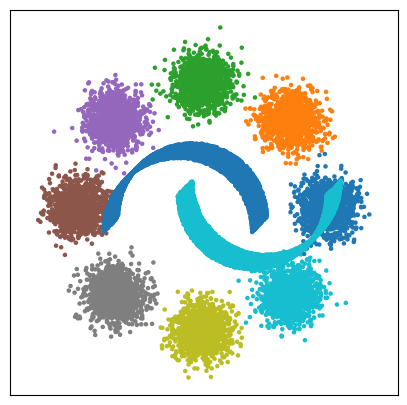

In [8]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

display(gauss_sample,  ax=ax, s=5, cmap="tab10")
display(moon_sample, ax=ax, s=5, cmap="tab10")

In [ ]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import softmax
import numpy as np


class MLP(torch.nn.Module):
    def __init__(self, dim_input, dim_output=None, dim_hidden=64):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim_input, dim_hidden),
            torch.nn.SELU(),
            torch.nn.Linear(dim_hidden, dim_hidden),
            torch.nn.SELU(),
            torch.nn.Linear(dim_hidden, dim_hidden),
            torch.nn.SELU(),
            torch.nn.Linear(dim_hidden, dim_output),
        )

    def forward(self, x):
        return self.net(x)


class MultiModalMLP(nn.Module):
    """MLP architecture for hybrid continuous-discrete models"""

    def __init__(self, dim_continuous, dim_discrete, vocab_size, dim_hidden=64):
        super().__init__()

        self.embed_discrete = nn.Embedding(vocab_size, dim_hidden)
        
        self.body = MLP(dim_continuous, vocab_size, dim_hidden)
        self.continous_head = torch.nn.Linear(dim_hidden, dim_continuous)
        self.discrete_head = torch.nn.Linear(dim_hidden, vocab_size)

    def forward(self, state: TensorMultiModal):

        h = torch.cat([state.time, 
                       state.continuous, 
                       self.embed(state.discrete)], dim=-1)    

        h = self.body(h) 
        x = self.continous_head(h)
        k = self.discrete_head(h).reshape()
        return TensorMultiModal(continuous=x, discrete=k)


In [ ]:

from datamodules.datasets import DataCoupling
from model.bridges import UniformLinearFlow, TelegraphBridge 

%%time


# data init
gaussians = NGaussians(dim=2, vocab_size=8)
moons = TwoMoons(dim=2)
batch_size = 256

# model init
bridge_continuous = UniformLinearFlow(sigma=0.01)
bridge_discrete = TelegraphBridge(gamma=0.1, vocab_size=8)
mse = torch.nn.MSELoss(reduce="mean")
cross_entropy = torch.nn.CrossEntropyLoss(reduce="mean")

# neural network init
model = MultiModalMLP(dim=2)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()

for k in range(20000):
    optimizer.zero_grad()

    # define source-target enpopints coupling
    source = gaussians(batch_size)
    target = moons(batch_size)
    batch = DataCoupling(source, target)

    # sample time and bridge state
    time = torch.rand(len(batch))
    continuous_state = bridge_continuous.sample(time, batch)
    discrete_state = bridge_discrete.sample(time, batch)
    multimodal_state = TensorMultiModal(time=time, 
                                        continuous=continuous_state, 
                                        discrete=discrete_state)

    # neural network forward pass
    heads = model(multimodal_state)

    # flow-matching loss for continuous state
    vt  = heads.continuous
    ut = bridge_continuous.drift(multimodal_state, batch)  # x1 - x0
    loss_continuous = mse(vt, ut)

    # markov jump classifier loss for discrete state
    logits = heads.discrete
    targets = batch.target.discrete.squeeze(-1)
    loss_discrete = cross_entropy(logits, targets)

    # combine total loss and optimize
    loss = loss_continuous + loss_discrete
    loss.backward()
    optimizer.step()

    # if (k + 1) % 5000 == 0:
    #     end = time.time()
    #     print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    #     start = end
    #     node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    #     with torch.no_grad():
    #         traj = node.trajectory(sample_8gaussians(1024),t_span=torch.linspace(0, 1, 100),)
    #         plot_trajectories(traj.cpu().numpy())

In [ ]:
def loss_fn(
        self, heads: TensorMultiModal, state: TensorMultiModal, batch: DataCoupling
    ) -> torch.Tensor:
        loss_continuous = torch.tensor(0.0, device=self.device)
        loss_discrete = torch.tensor(0.0, device=self.device)

        if heads.has_continuous:
            """mean square error loss for drift matching
            """

            vector = heads.continuous
            targets = self.bridge_continuous.drift(state, batch).to(self.device)

            loss_mse = self.loss_continuous_fn(vector, targets) * state.mask
            loss_continuous = loss_mse.sum() / state.mask.sum()

        if heads.has_discrete:
            """cross-entropy loss for discrete state classifier
            """

            logits = heads.discrete.transpose(1, 2)
            targets = batch.target.discrete.squeeze(-1).to(self.device)

            loss_ce = self.loss_discrete_fn(logits, targets.long()).unsqueeze(-1) * state.mask 
            loss_discrete = loss_ce.sum() / state.mask.sum()

        return loss_continuous, loss_discrete